In [124]:
from basix import CellType, ElementFamily, LagrangeVariant, LatticeType
import numpy as np
import matplotlib.pyplot as plt
import bbax
import basix

In [125]:
import numpy as np
from scipy.special import comb
from numpy.polynomial.legendre import Legendre, leggauss


def compute_A_matrix_quad(max_k, max_n, sign, zero_tol=1e-14):
    """
    Compute the A_{kn}^{±} matrix by quadrature:
    A_{kn}^{sign} = sign * (2n + 1)/2 * ∫ P_k(x) * P_n(2x - sign) dx over [a,b]
    where [a,b] = [0,1] for sign=+1, [-1,0] for sign=-1

    Any entries with abs(value) < zero_tol are set to zero.
    """
    from numpy.polynomial.legendre import Legendre, leggauss
    import numpy as np

    assert sign in (+1, -1), "Sign must be +1 or -1"
    A = np.zeros((max_k + 1, max_n + 1))
    a, b = (0, 1) if sign == +1 else (-1, 0)
    Q = max_k + max_n + 5  # enough points for exactness
    x_gl, w_gl = leggauss(Q)
    x_mapped = 0.5 * (b - a) * x_gl + 0.5 * (b + a)
    w_mapped = 0.5 * (b - a) * w_gl
    for k in range(max_k + 1):
        Pk = Legendre.basis(k)(x_mapped)
        for n in range(max_n + 1):
            Pn = Legendre.basis(n)(2 * x_mapped - sign)
            integrand = Pk * Pn
            A[k, n] = sign * (2 * n + 1)  * np.dot(w_mapped, integrand)
    # Zero out small values
    A[np.abs(A) < zero_tol] = 0.0
    return A

#compute_A_matrix_quad(4,4, 1)



In [213]:
from typing import Iterable, List, Literal
from bbax.fem_1d import create_dof_matrix_vertex_interior, apply_marshak_bc, _apply_reflective_bc
from scipy.sparse import lil_matrix

def apply_DPN_vacuum(A, b, n_global_dofs, L_tot, left_dof, right_dof):
    for k in range(L_tot):
        #mu = -1 should apply to the right DOF
        row = right_dof + (2 * k) * n_global_dofs
        A[row, :]   = 0.0
        A[row, row] = 1.0
        b[row, 0 ]  = 0.0

        # mu = +1 should apply to the left DOF
        row = left_dof + (2 * k + 1) * n_global_dofs
        A[row, :]   = 0.0
        A[row, row] = 1.0
        b[row, 0 ]  = 0.0


def assemble_matrix(element : basix.finite_element.FiniteElement, nodes : np.ndarray, sigma_t : Iterable[float], sigma_s : List[np.ndarray], q : List[np.ndarray], N_max : int, bc : Literal["marshak", "reflective"]):
    '''
    Assemble the finite element matrix and right-hand side vector for the 1D transport equation.

    Parameters:
    -----------
    element: basix.Element
        The finite element to use for the assembly.
    nodes: np.ndarray
        Array of node positions in cm.
    sigma_t: list[np.ndarray(number_of_energy_groups)]
        List of arrays for total cross section in cm^-1 for each element.
    sigma_s: list[np.ndarray(max_scatter + 1, number_of_energy_groups, number_of_energy_groups)]
        List of scattering matrices for each element, where each matrix is of shape (max_scatter + 1, number_of_energy_groups, number_of_energy_groups).
        This corresponds to k, energy_group_out, energy_group_in. Note that max_scatter will not necessarily be equal to N_max. 
    q: array(number_of_elements, L_max + 1, element_degree + 1)
    


    '''
    # if N_max % 2 == 0:
    #     raise ValueError("N_max must be odd for this implementation.")
    
    n_elem = len(nodes) - 1

    L_tot = N_max + 1

    # =============================================
    # Compute overlap matrix scattering
    # =============================================
    A_kn_plus  = compute_A_matrix_quad(N_max, N_max, 1, zero_tol=1e-14)
    A_kn_minus = compute_A_matrix_quad(N_max, N_max, 1, zero_tol=1e-14)

    A_matrix = [A_kn_minus, A_kn_plus]  # A_kn_minus for mu < 0, A_kn_plus for mu >= 0
    
    # =============================================
    # Setting up finite element space
    # =============================================
    degree = element.degree    
    dof_elem = element.dim
    quad_deg = 4 * degree    
    points, weights = basix.make_quadrature(element.cell_type, quad_deg)

    phidphi = element.tabulate(1, points)
    phi = phidphi[0, :, :, 0]  # (n_quadrature_points, n_basis) = value at [quad_point, basis_no]
    dphi = phidphi[1, :, :, 0] # (n_quadrature_points, n_basis) = d value / dx at [quad_point, basis_no]
    
    hihj = np.einsum('qi,qj->qij', phi, phi)  # (n_qp, n_basis, n_basis)
    mass_matrix = np.tensordot(weights, hihj, axes=([0], [0])) # \int H_i H_j d\xi (no Jacobian)

    dhihj = np.einsum("qi, qj->qij", phi, dphi)
    local_streaming = np.tensordot(weights, dhihj, axes=([0], [0])) # \int H_i \partial_\xi H_j d\xi (no Jacobian)
    print(local_streaming)
    

    
    # =============================================
    # Global Matrix Setup
    # =============================================    
    dof_matrix, n_global_dofs = create_dof_matrix_vertex_interior(element, nodes)    
        # dof_matrix: (number_of_elements, dof_per_element)
        #    maps the local dof to a global dof
        # n_global_dofs: total number of global degrees of freedom

    
    # =============================================
    # Global Matrix assembly
    # =============================================    

    A = lil_matrix((n_global_dofs  * 2 * L_tot, n_global_dofs * 2 * L_tot), dtype=np.float64)
    b = lil_matrix((n_global_dofs * 2 * L_tot, 1), dtype=np.float64)

    # Function that calculates the total global degree of freedom for a given element and local index and k moment    
    def total_dof(element_i, local_i, k, mu_sign):
        if mu_sign == -1:
            mu_g_than_zero = 0
        elif mu_sign == 1:
            mu_g_than_zero = 1
        else:   
            raise ValueError("mu_sign must be either -1 or 1.")
        return dof_matrix[element_i, local_i] + ( 2 * k + mu_g_than_zero ) * n_global_dofs

    
    for k in range(L_tot):
        for mu_sign in (-1,1):            
            for i in range(n_elem):            
                
                no_dofs = len(dof_matrix[i])
                h = nodes[i+1] - nodes[i]           
                A_local = mass_matrix * h             
                B_local = local_streaming
                
                s_local = np.einsum("ij,kj -> ik", mass_matrix * h,  q[i]) # stupid hack for isotropic source [won't work for down scattering!]                
                
                for local_i in range(no_dofs):     # determines equation number 
                
                    b[total_dof(i, local_i, k, mu_sign), 0] += s_local[local_i, k]

                    for local_j in range(no_dofs): # determines contribution number
                        
                        # Collision term
                        A[total_dof(i, local_i, k, mu_sign), total_dof(i, local_j, k, mu_sign)]+= A_local[local_i, local_j] * sigma_t[i]

                        # Streaming term 
                        # Note that the equation number of the streaming term is k, so the first index should 
                        # correspond to the current k, and the second index should correspond to the different k.
                        if k != L_tot - 1:
                            A[total_dof(i, local_i, k, mu_sign), total_dof(i, local_j, k + 1, mu_sign)] +=\
                                B_local[local_i, local_j] * ( k + 1 ) / ( 2 * k + 1)  / 2.0                        
                        if k != 0:
                            A[total_dof(i, local_i, k, mu_sign), total_dof(i, local_j, k - 1, mu_sign)] +=\
                                B_local[local_i, local_j] * ( k ) / ( 2 * k + 1) / 2.0
                        
                        A[total_dof(i, local_i, k, mu_sign), total_dof(i, local_j, k, mu_sign)] += B_local[local_i, local_j] * 0.5 * mu_sign

                        # Scattering term (let's do isotropic for now)
                        if k  == 0:                            
                            # t = - 1
                            A[total_dof(i, local_i,k , mu_sign), total_dof(i, local_j, k, mu_sign = -1)] -= sigma_s[i][k] * A_local[local_i, local_j] / 2.0
                            # t = + 1
                            A[total_dof(i, local_i,k , mu_sign), total_dof(i, local_j, k, mu_sign = +1)] -= sigma_s[i][k] * A_local[local_i, local_j] / 2.0



    # =============================================
    # Apply boundary conditions
    # =============================================
    # Strongly imposed.

    if bc == "vacuum":
        apply_DPN_vacuum(A,b, n_global_dofs, L_tot, left_dof = 0, right_dof = nodes.shape[0] - 1)    
    else:
        raise ValueError(f"Unknown boundary condition: {bc}. Supported: 'reflective', 'marshak'.")
    
    return A, b

from bbax.fem_1d import build_elements_and_materials

elements_per_cm = 10
N_max = 1
energy_group = 0
elem_degree = 5


regions = [
    (2.0, [2.0], np.array([[[0.0]]]), [2.0]),
     (1.0, [1.0],  np.array([[[0.0]]]),  [0.0]),    
    (2.0, [1.0],  np.array([[[0.0]]]),  [0.0]),
    (1.0, [1.0],  np.array([[[0.9]]]), [1.0]),
    (2.0, [1.0],  np.array([[[0.9]]]), [0.0]),
]

element = basix.create_element(ElementFamily.P, CellType.interval, degree= elem_degree, lagrange_variant= LagrangeVariant.gll_warped)
nodes, sigma_t, sigma_s, q = build_elements_and_materials(regions, elements_per_cm, N_max, energy_group, element.dim)

bc = "vacuum"
A,b = assemble_matrix(element, nodes, sigma_t, sigma_s, q, N_max, bc)

[[-5.00000000e-01  3.33333333e-02  6.76094396e-01 -2.69079151e-01
   1.49645643e-01 -8.99942209e-02]
 [-3.33333333e-02  5.00000000e-01  8.99942209e-02 -1.49645643e-01
   2.69079151e-01 -6.76094396e-01]
 [-6.76094396e-01 -8.99942209e-02  3.61689845e-16  9.55053839e-01
  -4.36316587e-01  2.47351364e-01]
 [ 2.69079151e-01  1.49645643e-01 -9.55053839e-01  2.73652628e-16
   9.72645632e-01 -4.36316587e-01]
 [-1.49645643e-01 -2.69079151e-01  4.36316587e-01 -9.72645632e-01
  -2.20309881e-16  9.55053839e-01]
 [ 8.99942209e-02  6.76094396e-01 -2.47351364e-01  4.36316587e-01
  -9.55053839e-01 -1.66533454e-15]]


In [214]:
def interpolate_solution(x_points, nodes, elem_dofs, solution, lagrange, N_max, k = 0, mu_sign = 1):
    """
    Interpolate the FEM solution at arbitrary points x_points.

    Parameters:
    -----------
    x_points: array(n_points)
        Points at which to interpolate the solution.
    nodes: array(n_nodes)
        Nodes of the FEM mesh.
    elem_dofs: array(n_elements, p+1)
        Local DOF indices for each element.
    solution: array(n_global_dofs)
        Global solution vector.
    lagrange: basix.Element
        Lagrange element used for interpolation.

    Is rather slow: but for 1D, it works okay.

    
    Returns: array of interpolated values at x_points
    """
    
    values = np.zeros_like(x_points)
    
    n_global_dofs = solution.shape[0] // (N_max + 1) // 2
    
    if mu_sign not in (-1, 1):
        raise ValueError("mu_sign must be either -1 or 1.")
    if mu_sign == -1:   
        mu_extra = 0
    else:
        mu_extra = 1
    solution_k = solution[(2 * k + mu_extra) * n_global_dofs : (2 * k + mu_extra + 1) * n_global_dofs]
    
    # For each point, find which element it is in
    for i, x in enumerate(x_points):
        # Find the element containing x
        e = np.searchsorted(nodes, x) - 1
        if e < 0: e = 0
        if e >= len(elem_dofs): e = len(elem_dofs) - 1
        # Map x to reference coordinate xi in [0, 1]
        x0, x1 = nodes[e], nodes[e+1]
        xi = (x - x0) / (x1 - x0)
        # Tabulate basis at xi
        phi = lagrange.tabulate(0, np.array([[xi]]))[0, 0, :, 0]  # shape: (p+1,)
        
        # Get local DOF values
        u_local = solution_k[elem_dofs[e]]
        
        
        values[i] = np.dot(phi, u_local)
    return values


In [215]:
from scipy.sparse.linalg import spsolve
phi_vec = spsolve(A.tocsr(), b)

(1604,)


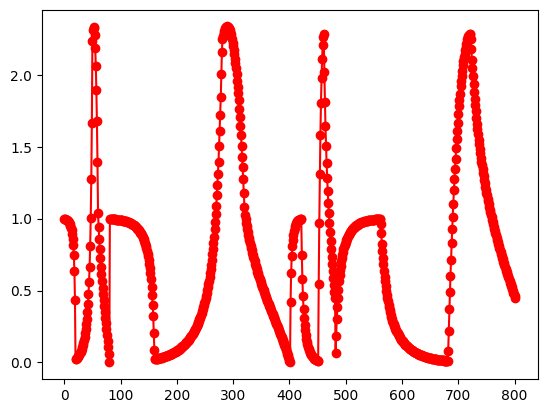

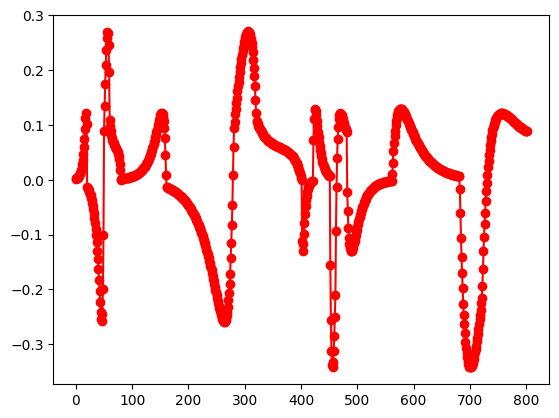

In [216]:
print(phi_vec.shape)
plt.plot(phi_vec[:int(phi_vec.shape[0] //2)],'ro-')

plt.figure()
plt.plot(phi_vec[int(phi_vec.shape[0] //2):],'ro-')


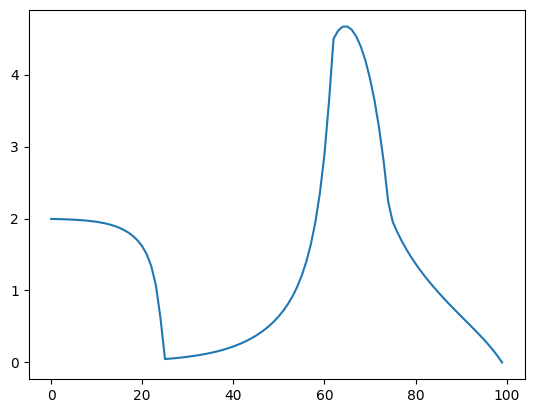

In [217]:
elem_dofs, _ = bbax.fem_1d.create_dof_matrix_vertex_interior(element, nodes)
plt.plot(interpolate_solution(np.linspace(0, 8.0, 100), nodes,  elem_dofs, phi_vec, element, N_max, mu_sign=-1) + interpolate_solution(np.linspace(0, 8.0, 100), nodes,  elem_dofs, phi_vec, element, N_max, mu_sign=-1))

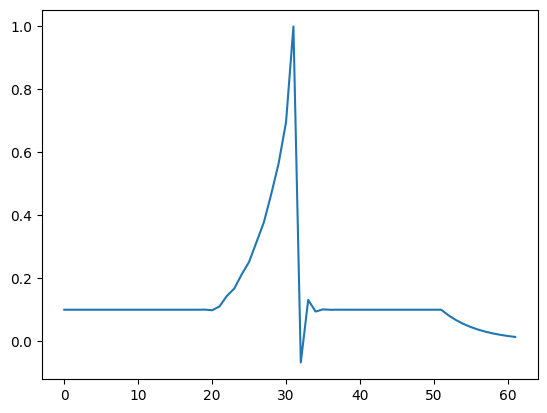

In [131]:
#print(phi_vec)

plt.plot(phi_vec)